## Import Dependencies 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [61]:
import time
import random
import sys
import gc

import gensim.models

from operator import itemgetter
from typing import Optional, List
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.manifold import TSNE

from src.enums import Fields, Measures, Methods
from src.models.Document import Document
from src.types import DocID
from src.utils.read_document import read_documents_json
from src.utils.extract_train_feature_matrix import extract_train_feature_matrix
from src.utils.extract_val_feature_matrix import extract_val_feature_matrix
from src.models.TextPreprocessor import (
    PersianTextPreprocessor,
    EnglishTextPreprocessor,
    TextPreprocessor,
)
from src.ml.MLMetrics import MLMetrics
from src.ml.KNN import KNN
from src.ml.NaiveBayes import NaiveBayes
from src.models.Manager import Manager
from src.ml.k_means import k_means

seed = 42
random.seed(seed)
np.random.seed(seed)
num_classes = 4

## Data Preparation Utils

In [4]:
def prepare_data(text_preprocessor: Optional[TextPreprocessor] = None):
    if text_preprocessor is None:
        text_preprocessor = EnglishTextPreprocessor(lemmatize=True)
    train_documents = read_documents_json(
        "./MIR_Phase2/data/train.json", text_preprocessor
    )
    val_documents = read_documents_json(
        "./MIR_Phase2/data/validation.json", text_preprocessor
    )
    manager = Manager(
        train_documents, [Fields.BODY, Fields.TITLE], text_preprocessor
    )
    train_labels = np.array([doc.category - 1 for doc in train_documents])
    val_labels = np.array([doc.category - 1 for doc in val_documents])
    return train_documents, val_documents, manager, train_labels, val_labels

In [5]:
def prepare_part_of_data(
    num_classes: int = 4,
    percent: float = 0.5,
    text_preprocessor: Optional[TextPreprocessor] = None,
):
    if text_preprocessor is None:
        text_preprocessor = EnglishTextPreprocessor(lemmatize=True)
    train_documents = read_documents_json(
        "./MIR_Phase2/data/train.json", text_preprocessor
    )
    val_documents = read_documents_json(
        "./MIR_Phase2/data/validation.json", text_preprocessor
    )
    train_labels = np.array([doc.category - 1 for doc in train_documents])
    val_labels = np.array([doc.category - 1 for doc in val_documents])

    class_indices = [
        np.nonzero(train_labels == class_)[0] for class_ in range(num_classes)
    ]

    chosen_indices = np.array(
        [
            np.random.choice(
                class_indices[class_],
                int(len(class_indices[class_]) * percent),
                replace=False,
            )
            for class_ in range(num_classes)
        ]
    ).flatten()

    train_documents = itemgetter(*chosen_indices)(train_documents)
    train_labels = itemgetter(*chosen_indices)(train_labels)

    for index, train_doc in enumerate(train_documents):
        train_doc.doc_id = index

    manager = Manager(
        train_documents, [Fields.BODY, Fields.TITLE], text_preprocessor
    )
    return train_documents, val_documents, manager, train_labels, val_labels

In [5]:
train_documents, val_documents, manager, train_labels, val_labels = (
    prepare_data()
)
fields = manager.fields
num_tokens = len(manager.corpus_index.index)
num_train_docs = len(manager.documents)
num_val_docs = len(val_documents)

100%|██████████| 24000/24000 [00:06<00:00, 3432.17it/s]


## KNN 

### Define Test Utils

In [21]:
k_choices = [1, 3, 5]

/home/alireza/PycharmProjects/MIR/src/numba_utils/__init__.py:8: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  sims = np.dot(mat1, mat2.T)
/home/alireza/PycharmProjects/MIR/src/numba_utils/__init__.py:28: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  train_dot_val = np.dot(train_matrix, val_matrix.T)


In [22]:
def test_knn(
    manager: Manager,
    val_documents: List[Document],
    val_labels: List[int],
    k_choices: List[int],
    measure: Measures = Measures.COSINE_SIMILARITY,
):
    knn = KNN(manager, val_documents, measure)
    knn.extract_feature_matrices()
    knn.calculate_measure()
    results = [np.array(knn.run(k)) - 1 for k in k_choices]
    for k, result in zip(k_choices, results):
        print(f"+++++ K: {k} +++++")
        cm = MLMetrics.compute_confusion_matrix(val_labels, result)
        MLMetrics.plot_confusion_matrix(
            cm,
            ["World", "Sports", "Business", "Sci/Tech"],
            ["World", "Sports", "Business", "Sci/Tech"],
            title=f"K: {k}",
            dpi=150,
        )
        MLMetrics.print_summary_metrics(cm)

### KNN with Cosine Similarity 

#### Results 

100%|██████████| 26952/26952 [00:14<00:00, 1905.03it/s]


+++++ K: 1 +++++


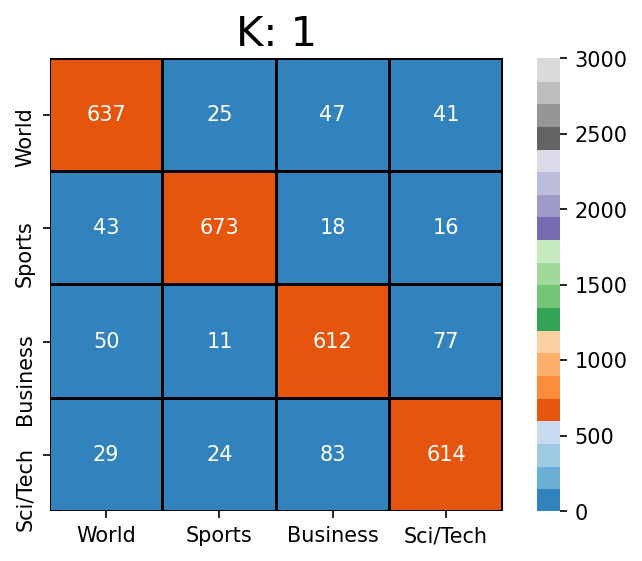

label precision recall
    1     0.839  0.849
    2     0.918  0.897
    3     0.805  0.816
    4     0.821  0.819
macro averaged precision: 0.845881392785794
macro averaged recall: 0.8453333333333333
accuracy: 0.8453333333333334
macro averaged recall f1: 0.8456072742567763
+++++ K: 3 +++++


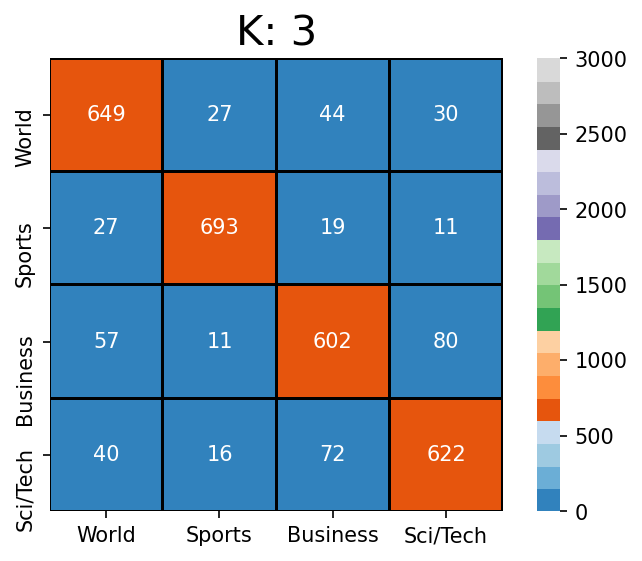

label precision recall
    1     0.840  0.865
    2     0.928  0.924
    3     0.817  0.803
    4     0.837  0.829
macro averaged precision: 0.8553171351174839
macro averaged recall: 0.8553333333333334
accuracy: 0.8553333333333333
macro averaged recall f1: 0.8553252341487178
+++++ K: 5 +++++


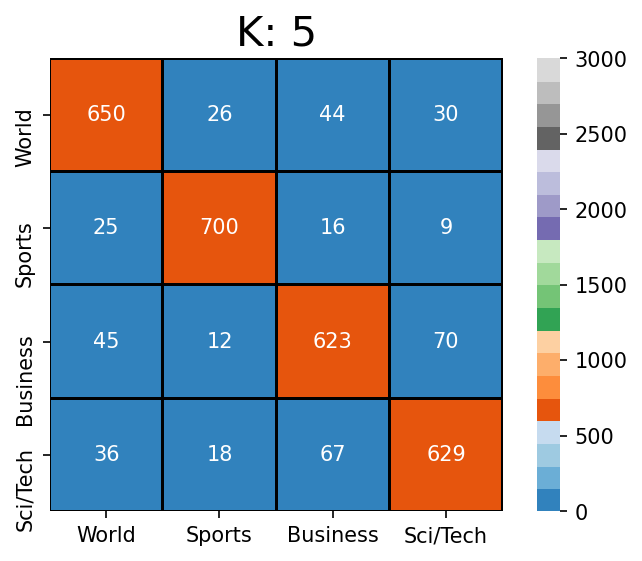

label precision recall
    1     0.860  0.867
    2     0.926  0.933
    3     0.831  0.831
    4     0.852  0.839
macro averaged precision: 0.8671711188540456
macro averaged recall: 0.8673333333333333
accuracy: 0.8673333333333333
macro averaged recall f1: 0.867252218508371


In [12]:
test_knn(
    manager, val_documents, val_labels, k_choices, Measures.COSINE_SIMILARITY
)

#### Conslusion 

Best setting with measure being cosine similarity is k = 5.

### KNN with Euclidean Distance

#### Results 

100%|██████████| 26952/26952 [00:13<00:00, 1998.15it/s]


+++++ K: 1 +++++


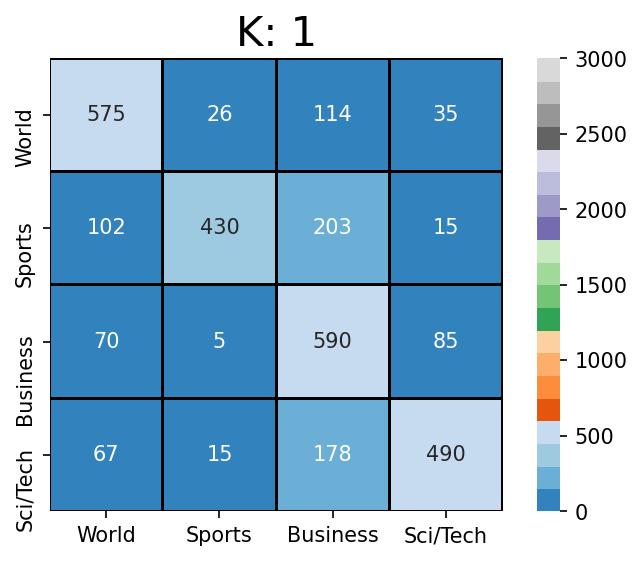

label precision recall
    1     0.706  0.767
    2     0.903  0.573
    3     0.544  0.787
    4     0.784  0.653
macro averaged precision: 0.7343820881923349
macro averaged recall: 0.6950000000000001
accuracy: 0.695
macro averaged recall f1: 0.7141485198532793
+++++ K: 3 +++++


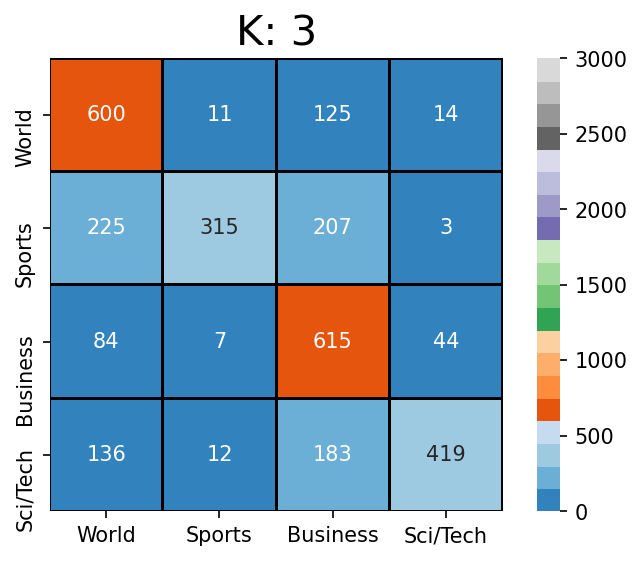

label precision recall
    1     0.574  0.800
    2     0.913  0.420
    3     0.544  0.820
    4     0.873  0.559
macro averaged precision: 0.7260926529909982
macro averaged recall: 0.6496666666666666
accuracy: 0.6496666666666666
macro averaged recall f1: 0.6857568570601402
+++++ K: 5 +++++


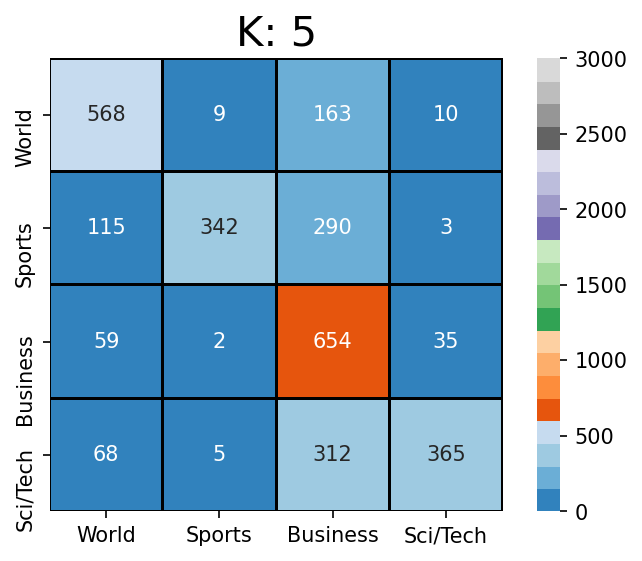

label precision recall
    1     0.701  0.757
    2     0.955  0.456
    3     0.461  0.872
    4     0.884  0.487
macro averaged precision: 0.7503017548601382
macro averaged recall: 0.643
accuracy: 0.643
macro averaged recall f1: 0.6925190852479726


In [13]:
test_knn(
    manager, val_documents, val_labels, k_choices, Measures.EUCLIDEAN_DISTANCE
)

#### Conclusion 

Best setting with measure being cosine similarity is k = 1.

## NaiveBayes

### Define Test Utils 

In [11]:
smoothing_options = [1, 5, 25, 50, 75, 100, 500, 1000]

In [14]:
def test_naive_bayes(
    manager: Manager,
    val_documents: List[Document],
    val_labels: List[int],
    smoothing_options: List[int],
    num_classes: int,
):
    results = []
    for smoothing in smoothing_options:
        clf = NaiveBayes(manager, smoothing, num_classes)
        clf.train()
        results.append(np.array(clf.test(val_documents)))
    for smoothing, result in zip(smoothing_options, results):
        print(f"+++++ Smoothing: {smoothing} +++++")
        cm = MLMetrics.compute_confusion_matrix(val_labels, result)
        MLMetrics.plot_confusion_matrix(
            cm,
            ["World", "Sports", "Business", "Sci/Tech"],
            ["World", "Sports", "Business", "Sci/Tech"],
            title=f"Smoothing: {smoothing}",
            dpi=150,
        )
        MLMetrics.print_summary_metrics(cm)

### Results 

+++++ Smoothing: 1 +++++


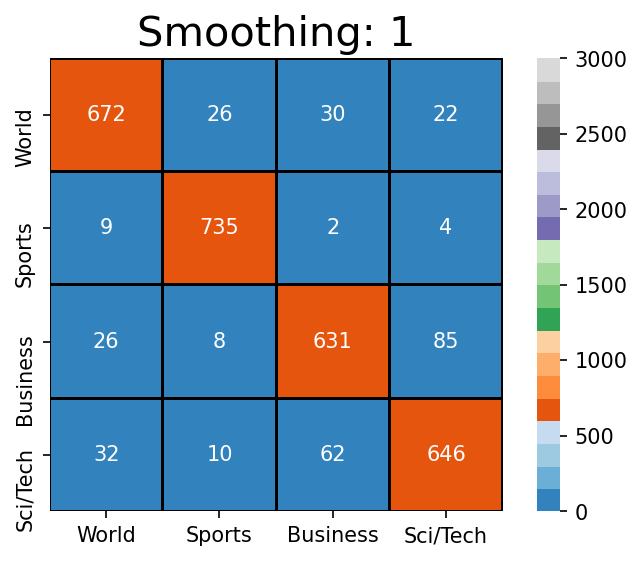

label precision recall
    1     0.909  0.896
    2     0.944  0.980
    3     0.870  0.841
    4     0.853  0.861
macro averaged precision: 0.8941419148538224
macro averaged recall: 0.8946666666666667
accuracy: 0.8946666666666667
macro averaged recall f1: 0.8944042137915661
+++++ Smoothing: 5 +++++


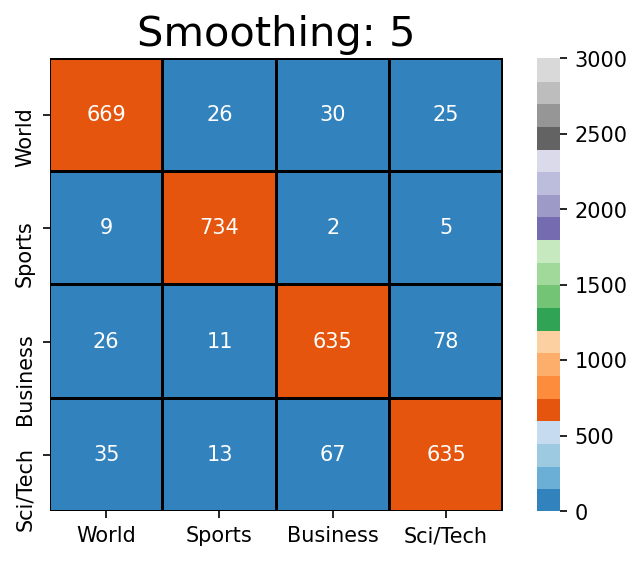

label precision recall
    1     0.905  0.892
    2     0.936  0.979
    3     0.865  0.847
    4     0.855  0.847
macro averaged precision: 0.8903169613284587
macro averaged recall: 0.891
accuracy: 0.891
macro averaged recall f1: 0.890658349710043
+++++ Smoothing: 25 +++++


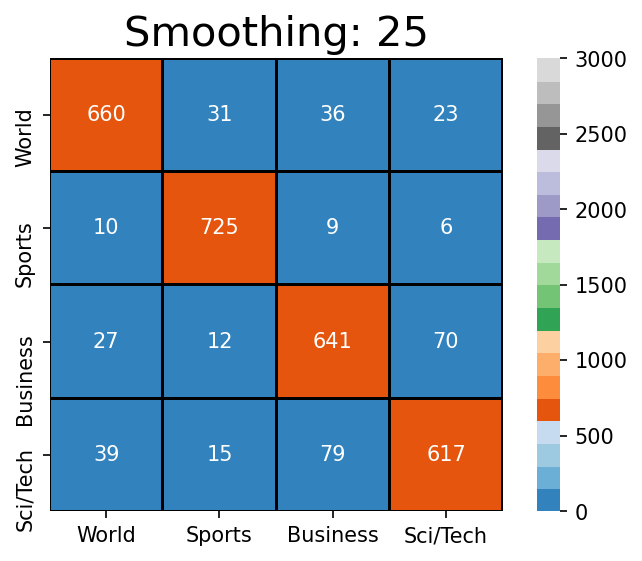

label precision recall
    1     0.897  0.880
    2     0.926  0.967
    3     0.838  0.855
    4     0.862  0.823
macro averaged precision: 0.8805763491670384
macro averaged recall: 0.881
accuracy: 0.881
macro averaged recall f1: 0.8807881236405021
+++++ Smoothing: 50 +++++


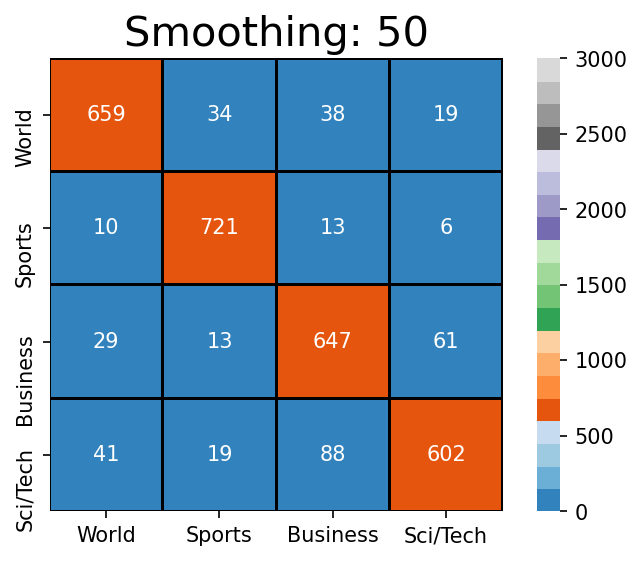

label precision recall
    1     0.892  0.879
    2     0.916  0.961
    3     0.823  0.863
    4     0.875  0.803
macro averaged precision: 0.8765095121093421
macro averaged recall: 0.8763333333333333
accuracy: 0.8763333333333333
macro averaged recall f1: 0.8764214138674461
+++++ Smoothing: 75 +++++


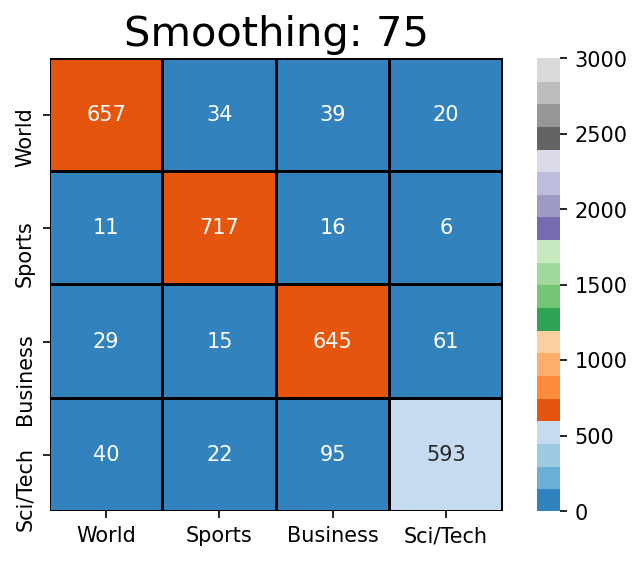

label precision recall
    1     0.891  0.876
    2     0.910  0.956
    3     0.811  0.860
    4     0.872  0.791
macro averaged precision: 0.8711824717885231
macro averaged recall: 0.8706666666666666
accuracy: 0.8706666666666667
macro averaged recall f1: 0.8709244928561922
+++++ Smoothing: 100 +++++


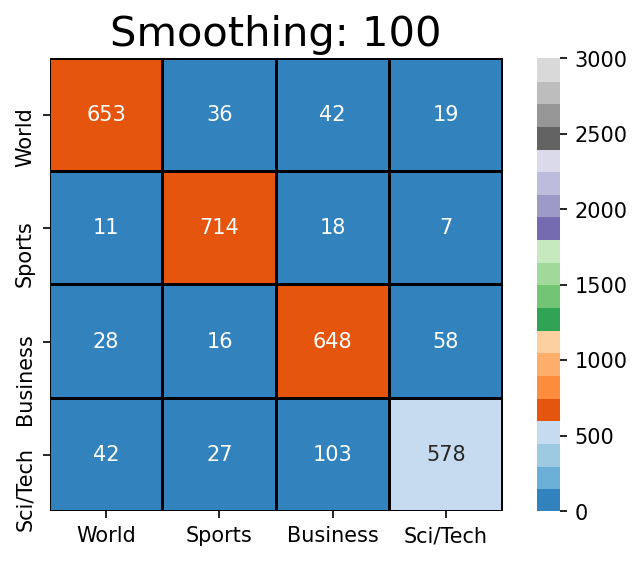

label precision recall
    1     0.890  0.871
    2     0.900  0.952
    3     0.799  0.864
    4     0.873  0.771
macro averaged precision: 0.865537358190081
macro averaged recall: 0.8643333333333333
accuracy: 0.8643333333333333
macro averaged recall f1: 0.864934926748927
+++++ Smoothing: 500 +++++


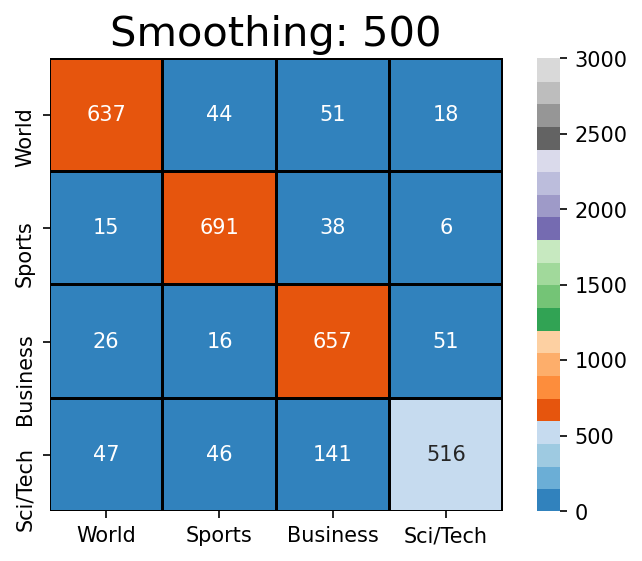

label precision recall
    1     0.879  0.849
    2     0.867  0.921
    3     0.741  0.876
    4     0.873  0.688
macro averaged precision: 0.83985434410117
macro averaged recall: 0.8336666666666666
accuracy: 0.8336666666666667
macro averaged recall f1: 0.8367490662230751
+++++ Smoothing: 1000 +++++


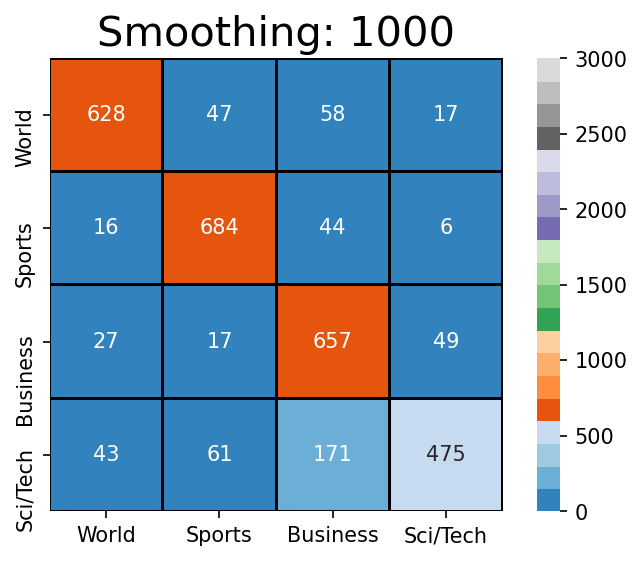

label precision recall
    1     0.880  0.837
    2     0.845  0.912
    3     0.706  0.876
    4     0.868  0.633
macro averaged precision: 0.8249661585165742
macro averaged recall: 0.8146666666666667
accuracy: 0.8146666666666667
macro averaged recall f1: 0.8197840640283516


In [15]:
test_naive_bayes(
    manager, val_documents, val_labels, smoothing_options, num_classes
)

### Conclusion 

The model with smoothing = 1 achieves the best results.

## Preprocessing Effect on the Results 

In [6]:
settings = [
    #     {"stem": False, "lemmatize": False, "del_stop_words": False}, # This setting leads to  memory error on systems with 16GB or less RAM
    {
        "stem": True,
        "lemmatize": False,
        "del_stop_words": False,
        "stemmer": "porter",
    },
    {
        "stem": False,
        "lemmatize": True,
        "del_stop_words": False,
        "stemmer": "porter",
    },
    {
        "stem": False,
        "lemmatize": False,
        "del_stop_words": True,
        "stemmer": "porter",
    },
    {
        "stem": False,
        "lemmatize": True,
        "del_stop_words": True,
        "stemmer": "porter",
    },
    {
        "stem": True,
        "lemmatize": False,
        "del_stop_words": True,
        "stemmer": "porter",
    },
    {
        "stem": True,
        "lemmatize": True,
        "del_stop_words": False,
        "stemmer": "porter",
    },
    {
        "stem": True,
        "lemmatize": True,
        "del_stop_words": True,
        "stemmer": "porter",
    },
    {
        "stem": True,
        "lemmatize": True,
        "del_stop_words": True,
        "stemmer": "lancaster",
    },
    {
        "stem": True,
        "lemmatize": False,
        "del_stop_words": True,
        "stemmer": "lancaster",
    },
]

In [7]:
def test_naive_bayes(
    manager: Manager,
    val_documents: List[Document],
    val_labels: List[int],
    smoothing: int,
    num_classes: int,
    plot_cm: bool = False,
    plot_title: str = "",
):
    clf = NaiveBayes(manager, smoothing, num_classes)
    clf.train()
    result = np.array(clf.test(val_documents))
    cm = MLMetrics.compute_confusion_matrix(val_labels, result)
    if plot_cm:
        MLMetrics.plot_confusion_matrix(
            cm,
            ["World", "Sports", "Business", "Sci/Tech"],
            ["World", "Sports", "Business", "Sci/Tech"],
            title=plot_title,
            dpi=150,
        )
    MLMetrics.print_summary_metrics(cm)
    return MLMetrics.f1_macro_average(cm)

In [8]:
def test_knn(
    manager: Manager,
    val_documents: List[Document],
    val_labels: List[int],
    k: int,
    measure: Measures = Measures.COSINE_SIMILARITY,
    plot_cm: bool = False,
    plot_title: str = "",
):
    knn = KNN(manager, val_documents, measure)
    knn.extract_feature_matrices()
    manager.clear_indexes()
    knn.calculate_measure()
    result = np.array(knn.run(k)) - 1
    cm = MLMetrics.compute_confusion_matrix(val_labels, result)
    if plot_cm:
        MLMetrics.plot_confusion_matrix(
            cm,
            ["World", "Sports", "Business", "Sci/Tech"],
            ["World", "Sports", "Business", "Sci/Tech"],
            title=plot_title,
            dpi=150,
        )
    MLMetrics.print_summary_metrics(cm)
    return MLMetrics.f1_macro_average(cm)

In [9]:
results = []
for setting in settings:
    gc.collect()
    text_preprocessor = EnglishTextPreprocessor(**setting)
    train_documents, val_documents, manager, train_labels, val_labels = prepare_data(
        text_preprocessor
    )
    fields = manager.fields
    num_tokens = len(manager.corpus_index.index)
    num_train_docs = len(manager.documents)
    num_val_docs = len(val_documents)
    print("Current Setting:")
    print(setting)
    print("Naive Bayes results:")
    f1 = test_naive_bayes(
        manager,
        val_documents,
        val_labels,
        smoothing=1,
        num_classes=num_classes,
    )
    results.append((setting, "NaiveBayes", f1))
    gc.collect()
    print("KNN results:")
    f1 = test_knn(
        manager,
        val_documents,
        val_labels,
        k=1,
        measure=Measures.COSINE_SIMILARITY,
    )
    results.append((setting, "KNN", f1))

100%|██████████| 24000/24000 [00:09<00:00, 2534.62it/s]


Current Setting:
{'stem': True, 'lemmatize': False, 'del_stop_words': False, 'stemmer': 'porter'}
Naive Bayes results:


  0%|          | 8/27138 [00:00<06:40, 67.78it/s]

label precision recall
    1     0.909  0.897
    2     0.938  0.981
    3     0.871  0.837
    4     0.855  0.860
macro averaged precision: 0.893372306434829
macro averaged recall: 0.894
accuracy: 0.894
macro averaged recall f1: 0.8936860429999712
KNN results:


100%|██████████| 27138/27138 [00:14<00:00, 1844.33it/s]


label precision recall
    1     0.841  0.851
    2     0.911  0.897
    3     0.804  0.812
    4     0.815  0.809
macro averaged precision: 0.8426315865191267
macro averaged recall: 0.8423333333333334
accuracy: 0.8423333333333334
macro averaged recall f1: 0.8424824335295491


100%|██████████| 24000/24000 [00:09<00:00, 2530.98it/s]


Current Setting:
{'stem': False, 'lemmatize': True, 'del_stop_words': False, 'stemmer': 'porter'}
Naive Bayes results:
label precision recall
    1     0.909  0.893
    2     0.935  0.983
    3     0.877  0.835
    4     0.859  0.872
macro averaged precision: 0.8951290823456902
macro averaged recall: 0.8956666666666666
accuracy: 0.8956666666666667
macro averaged recall f1: 0.8953977938166575


  0%|          | 7/33932 [00:00<08:06, 69.67it/s]

KNN results:


100%|██████████| 33932/33932 [00:17<00:00, 1923.38it/s]


label precision recall
    1     0.832  0.859
    2     0.922  0.901
    3     0.806  0.808
    4     0.823  0.813
macro averaged precision: 0.8458354159925127
macro averaged recall: 0.8453333333333334
accuracy: 0.8453333333333334
macro averaged recall f1: 0.8455843001325142


100%|██████████| 24000/24000 [00:07<00:00, 3345.44it/s]


Current Setting:
{'stem': False, 'lemmatize': False, 'del_stop_words': True, 'stemmer': 'porter'}
Naive Bayes results:
label precision recall
    1     0.905  0.887
    2     0.945  0.980
    3     0.870  0.840
    4     0.855  0.869
macro averaged precision: 0.8935448382257271
macro averaged recall: 0.8939999999999999
accuracy: 0.894
macro averaged recall f1: 0.8937723611640399


  0%|          | 34/37810 [00:00<02:27, 256.07it/s]

KNN results:


100%|██████████| 37810/37810 [00:21<00:00, 1740.59it/s]


label precision recall
    1     0.836  0.855
    2     0.917  0.899
    3     0.795  0.807
    4     0.829  0.815
macro averaged precision: 0.8441934016163923
macro averaged recall: 0.8436666666666667
accuracy: 0.8436666666666667
macro averaged recall f1: 0.843929951951746


100%|██████████| 24000/24000 [00:08<00:00, 2683.20it/s]


Current Setting:
{'stem': False, 'lemmatize': True, 'del_stop_words': True, 'stemmer': 'porter'}
Naive Bayes results:
label precision recall
    1     0.910  0.893
    2     0.946  0.983
    3     0.873  0.840
    4     0.852  0.867
macro averaged precision: 0.8952218453579429
macro averaged recall: 0.8956666666666666
accuracy: 0.8956666666666667
macro averaged recall f1: 0.8954442007698942


  0%|          | 33/33813 [00:00<02:10, 258.48it/s]

KNN results:


100%|██████████| 33813/33813 [00:23<00:00, 1438.98it/s]


label precision recall
    1     0.829  0.855
    2     0.919  0.895
    3     0.801  0.809
    4     0.829  0.817
macro averaged precision: 0.8446764255760384
macro averaged recall: 0.8440000000000001
accuracy: 0.844
macro averaged recall f1: 0.8443380773116328


100%|██████████| 24000/24000 [00:07<00:00, 3313.53it/s]


Current Setting:
{'stem': True, 'lemmatize': False, 'del_stop_words': True, 'stemmer': 'porter'}
Naive Bayes results:
label precision recall
    1     0.907  0.896
    2     0.943  0.979
    3     0.870  0.840
    4     0.853  0.861
macro averaged precision: 0.893465406783068
macro averaged recall: 0.8939999999999999
accuracy: 0.894
macro averaged recall f1: 0.893732623448754


  0%|          | 25/27038 [00:00<02:05, 215.64it/s]

KNN results:


100%|██████████| 27038/27038 [00:17<00:00, 1538.07it/s]


label precision recall
    1     0.839  0.851
    2     0.920  0.899
    3     0.804  0.816
    4     0.822  0.817
macro averaged precision: 0.8462258407504288
macro averaged recall: 0.8456666666666667
accuracy: 0.8456666666666667
macro averaged recall f1: 0.8459461613044338


100%|██████████| 24000/24000 [00:11<00:00, 2128.45it/s]


Current Setting:
{'stem': True, 'lemmatize': True, 'del_stop_words': False, 'stemmer': 'porter'}
Naive Bayes results:


  0%|          | 0/27047 [00:00<?, ?it/s]

label precision recall
    1     0.909  0.896
    2     0.938  0.983
    3     0.871  0.835
    4     0.853  0.860
macro averaged precision: 0.8927060659353232
macro averaged recall: 0.8933333333333333
accuracy: 0.8933333333333333
macro averaged recall f1: 0.8930195894843538
KNN results:


100%|██████████| 27047/27047 [00:18<00:00, 1431.15it/s]


label precision recall
    1     0.844  0.852
    2     0.911  0.899
    3     0.805  0.811
    4     0.813  0.811
macro averaged precision: 0.8432661452548429
macro averaged recall: 0.843
accuracy: 0.843
macro averaged recall f1: 0.8431330516244211


100%|██████████| 24000/24000 [00:07<00:00, 3423.93it/s]


Current Setting:
{'stem': True, 'lemmatize': True, 'del_stop_words': True, 'stemmer': 'porter'}
Naive Bayes results:


  0%|          | 32/26952 [00:00<01:28, 303.90it/s]

label precision recall
    1     0.909  0.896
    2     0.944  0.980
    3     0.870  0.841
    4     0.853  0.861
macro averaged precision: 0.8941419148538224
macro averaged recall: 0.8946666666666667
accuracy: 0.8946666666666667
macro averaged recall f1: 0.8944042137915661
KNN results:


100%|██████████| 26952/26952 [00:13<00:00, 1980.93it/s]


label precision recall
    1     0.839  0.849
    2     0.918  0.897
    3     0.805  0.816
    4     0.821  0.819
macro averaged precision: 0.845881392785794
macro averaged recall: 0.8453333333333333
accuracy: 0.8453333333333334
macro averaged recall f1: 0.8456072742567763


100%|██████████| 24000/24000 [00:08<00:00, 2974.85it/s]


Current Setting:
{'stem': True, 'lemmatize': True, 'del_stop_words': True, 'stemmer': 'lancaster'}
Naive Bayes results:
label precision recall
    1     0.909  0.891
    2     0.938  0.976
    3     0.867  0.835
    4     0.853  0.868
macro averaged precision: 0.8918880240327872
macro averaged recall: 0.8923333333333333
accuracy: 0.8923333333333333
macro averaged recall f1: 0.8921106231124966


  0%|          | 25/23435 [00:00<01:34, 248.10it/s]

KNN results:


100%|██████████| 23435/23435 [00:15<00:00, 1538.29it/s]


label precision recall
    1     0.844  0.844
    2     0.907  0.893
    3     0.797  0.809
    4     0.808  0.807
macro averaged precision: 0.8387405416468806
macro averaged recall: 0.8383333333333334
accuracy: 0.8383333333333334
macro averaged recall f1: 0.8385368880532237


100%|██████████| 24000/24000 [00:07<00:00, 3038.24it/s]


Current Setting:
{'stem': True, 'lemmatize': False, 'del_stop_words': True, 'stemmer': 'lancaster'}
Naive Bayes results:
label precision recall
    1     0.908  0.891
    2     0.937  0.977
    3     0.867  0.836
    4     0.855  0.865
macro averaged precision: 0.8918103074713559
macro averaged recall: 0.8923333333333334
accuracy: 0.8923333333333333
macro averaged recall f1: 0.8920717437392202


  0%|          | 14/23649 [00:00<02:53, 136.49it/s]

KNN results:


100%|██████████| 23649/23649 [00:21<00:00, 1077.21it/s]


label precision recall
    1     0.843  0.845
    2     0.908  0.891
    3     0.796  0.808
    4     0.807  0.808
macro averaged precision: 0.8384846334956423
macro averaged recall: 0.8380000000000001
accuracy: 0.838
macro averaged recall f1: 0.8382422466995724


In [14]:
best = np.argmax(list([x[2] for x in results]))
print(f"Best result: {results[best]}")
worst = np.argmin(list([x[2] for x in results]))
print(f"Worst result: {results[worst]}")

Best result: ({'stem': False, 'lemmatize': True, 'del_stop_words': True, 'stemmer': 'porter'}, 'NaiveBayes', 0.8954442007698942)
Worst result: ({'stem': True, 'lemmatize': False, 'del_stop_words': True, 'stemmer': 'lancaster'}, 'KNN', 0.8382422466995724)


## SVC 

In [7]:
train_documents, val_documents, manager, train_labels, val_labels = prepare_part_of_data(
    percent=0.2
)
train_feature_matrix = extract_train_feature_matrix(manager)
val_feature_matrix = extract_val_feature_matrix(manager, val_documents)
manager = None

100%|██████████| 13004/13004 [00:08<00:00, 1481.08it/s]


In [8]:
s = time.time()
clf = SVC(C=1.0, kernel="linear")
clf.fit(train_feature_matrix, train_labels)
e = time.time()

In [12]:
pred = clf.predict(val_feature_matrix)

array([3, 0, 3, ..., 0, 0, 0])

## RandomForest 

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
train_documents, val_documents, manager, train_labels, val_labels = (
    prepare_data()
)
train_feature_matrix = extract_train_feature_matrix(manager)
val_feature_matrix = extract_val_feature_matrix(manager, val_documents)

100%|██████████| 26952/26952 [00:16<00:00, 1586.17it/s]


In [29]:
settings = [
    {"n_estimators": 25, "max_depth": 50},
    {"n_estimators": 100, "max_depth": 50},
    {"n_estimators": 25, "max_depth": 100},
    {"n_estimators": 100, "max_depth": 100},
]

In [31]:
results = []
for setting in settings:
    clf = RandomForestClassifier(random_state=seed, **setting)
    clf.fit(train_feature_matrix, train_labels)
    predicted = clf.predict(val_feature_matrix)
    cm = MLMetrics.compute_confusion_matrix(val_labels, predicted)
    print(f"Current setting: {setting}")
    MLMetrics.print_summary_metrics(cm)
    results.append((setting, MLMetrics.f1_macro_average(cm)))

Current setting: {'n_estimators': 25, 'max_depth': 50}
label precision recall
    1     0.855  0.816
    2     0.826  0.960
    3     0.842  0.783
    4     0.835  0.796
macro averaged precision: 0.8393956216151024
macro averaged recall: 0.8386666666666667
accuracy: 0.8386666666666667
macro averaged recall f1: 0.839030985810851
Current setting: {'n_estimators': 100, 'max_depth': 50}
label precision recall
    1     0.874  0.833
    2     0.836  0.971
    3     0.861  0.799
    4     0.840  0.804
macro averaged precision: 0.852602955659272
macro averaged recall: 0.8516666666666668
accuracy: 0.8516666666666667
macro averaged recall f1: 0.8521345539744747
Current setting: {'n_estimators': 25, 'max_depth': 100}
label precision recall
    1     0.859  0.848
    2     0.853  0.963
    3     0.858  0.808
    4     0.845  0.797
macro averaged precision: 0.8539692660780109
macro averaged recall: 0.8540000000000001
accuracy: 0.854
macro averaged recall f1: 0.8539846327624859
Current setting: {'n

In [33]:
best = np.argmax(list([x[1] for x in results]))
print(f"Best result: {results[best]}")
worst = np.argmin(list([x[1] for x in results]))
print(f"Worst result: {results[worst]}")

Best result: ({'n_estimators': 100, 'max_depth': 100}, 0.8671685675234079)
Worst result: ({'n_estimators': 25, 'max_depth': 50}, 0.839030985810851)


## K-Means & TSNE

In [6]:
train_documents, val_documents, manager, train_labels, val_labels = (
    prepare_data()
)
num_train_docs = len(train_documents)
train_feature_matrix = extract_train_feature_matrix(manager)

100%|██████████| 26952/26952 [00:05<00:00, 5249.90it/s] 


In [31]:
num_iterations = 20
num_centers = num_classes
initial_centroids = train_feature_matrix[
    np.random.randint(0, num_train_docs, size=num_centers)
]

In [32]:
centroids, labels = k_means(
    train_feature_matrix, initial_centroids, num_centers, num_iterations
)

In [33]:
class_size = 100
class_indices = [
    np.nonzero(train_labels == class_)[0] for class_ in range(num_classes)
]

chosen_indices = np.array(
    [
        np.random.choice(class_indices[class_], class_size, replace=False)
        for class_ in range(num_classes)
    ]
).flatten()
chosen_train_documents = train_feature_matrix[chosen_indices]
chosen_labels = labels[chosen_indices]

In [42]:
chosen_train_documents = np.append(chosen_train_documents, centroids, axis=0)

In [43]:
colors = ["wheat", "red", "olive", "yellow"]
original_colors = []
for i in range(num_classes):
    original_colors += [colors[i]] * class_size
original_colors += ["navy"] * 4

In [44]:
k_means_colors = []
for label in chosen_labels:
    k_means_colors += [colors[label]]
k_means_colors += ["navy"] * 4

In [45]:
markers = [".", ",", "o", "v", "^", "<", ">"]

### 3D 

In [58]:
tsne = TSNE(n_components=3)
X_embedded = tsne.fit_transform(chosen_train_documents)

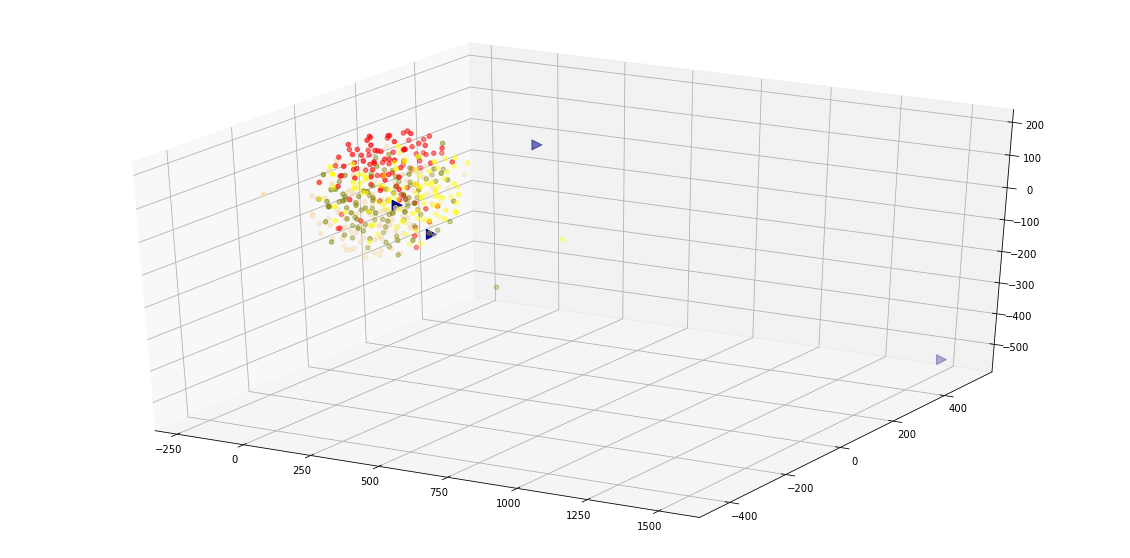

In [59]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X_embedded[:-4, 0], X_embedded[:-4, 1], X_embedded[:-4, 2], c=original_colors[:-4]
)
ax.scatter(
    X_embedded[-4:, 0],
    X_embedded[-4:, 1],
    X_embedded[-4:, 2],
    c=original_colors[-4:],
    marker=">",
    s=100,
)
plt.show()

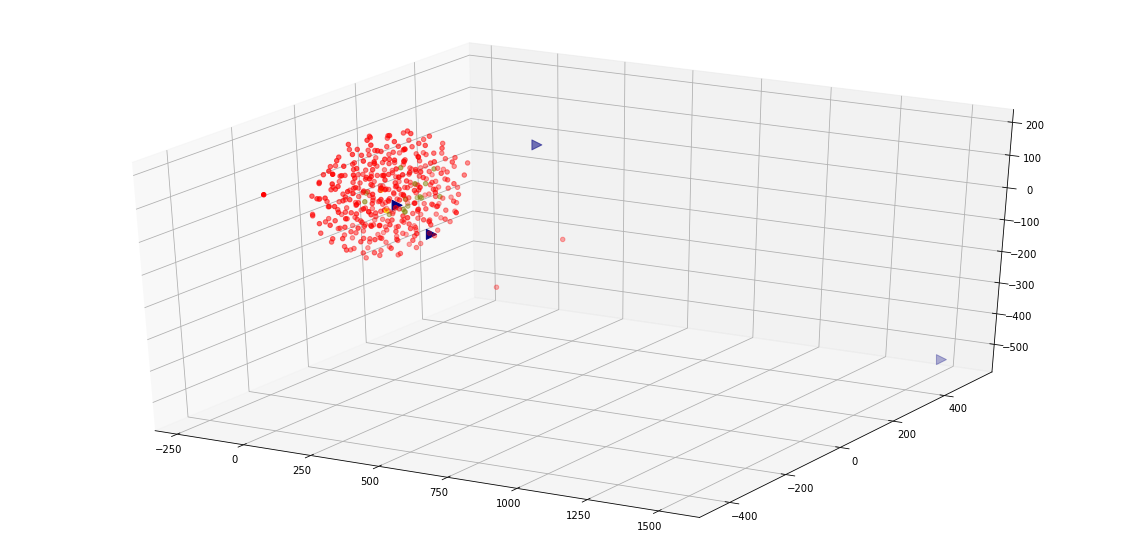

In [60]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X_embedded[:-4, 0], X_embedded[:-4, 1], X_embedded[:-4, 2], c=k_means_colors[:-4]
)
ax.scatter(
    X_embedded[-4:, 0],
    X_embedded[-4:, 1],
    X_embedded[-4:, 2],
    c=k_means_colors[-4:],
    marker=">",
    s=100,
)
plt.show()

### 2D 

In [52]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(chosen_train_documents)

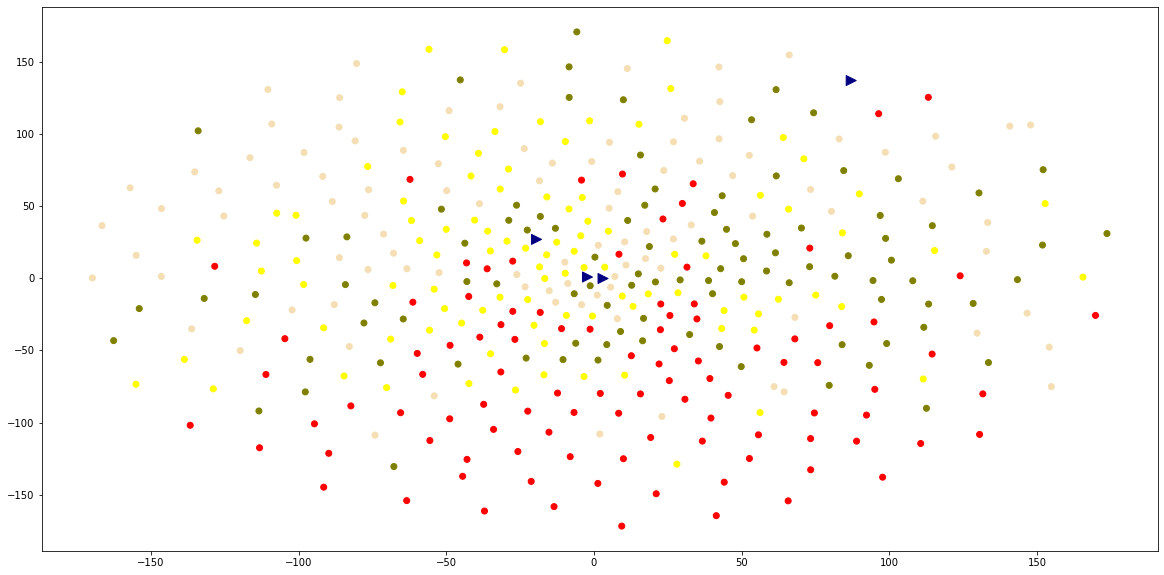

In [56]:
plt.figure(figsize=(20, 10))
plt.scatter(X_embedded[:-4, 0], X_embedded[:-4, 1], c=original_colors[:-4])
plt.scatter(X_embedded[-4:, 0], X_embedded[-4:, 1], c=original_colors[-4:], marker=">", s=100)

plt.show()

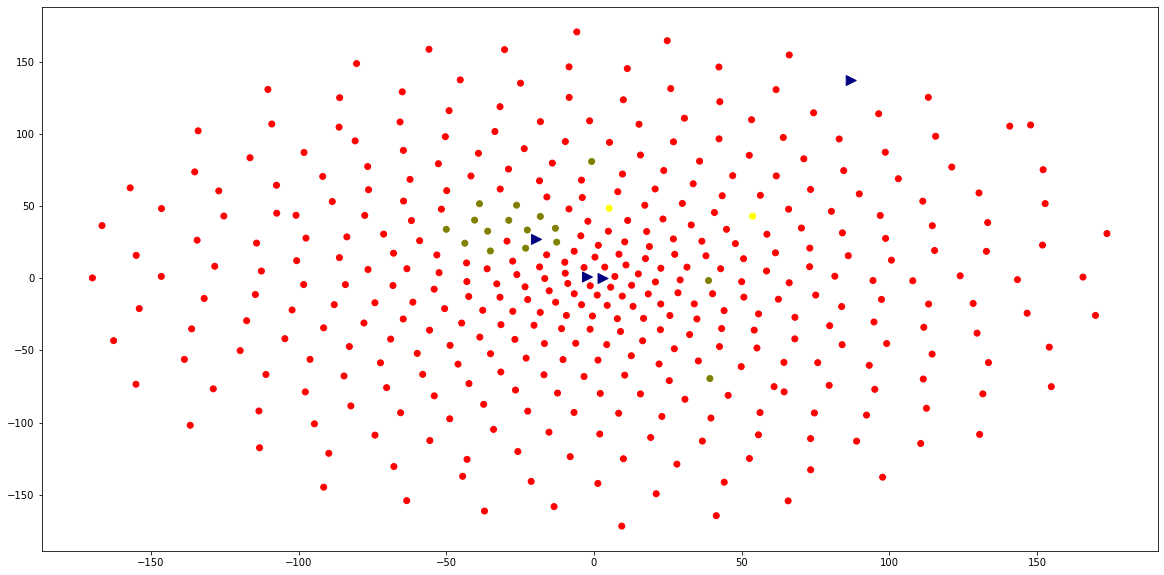

In [57]:
plt.figure(figsize=(20, 10))
plt.scatter(X_embedded[:-4, 0], X_embedded[:-4, 1], c=k_means_colors[:-4])
plt.scatter(X_embedded[-4:, 0], X_embedded[-4:, 1], c=k_means_colors[-4:], marker=">", s=100)

plt.show()

## Word2Vec 

In [62]:
class Dataloader:
    def __init__(self, documents: List[Document], fields: List[Fields]):
        self.documents = documents
        self.fields = fields

    def __iter__(self):
        for doc in self.documents:
            for field in self.fields:
                yield doc.get_tokens(field)

In [64]:
dataloader = Dataloader(train_documents, manager.fields)

In [67]:
window = 5
size = 100

In [65]:
model = gensim.models.Word2Vec(sentences=dataloader, window=window, size=size)

In [68]:
new_train_feature_matrix = np.zeros((num_train_docs, size), dtype=np.float32)
for doc_id, train_doc in enumerate(train_documents):
    num_doc_tokens = 0
    for field in manager.fields:
        for token in train_doc.get_tokens(field):
            try:
                new_train_feature_matrix[doc_id] += model.wv[token]
                num_doc_tokens += 1
            except KeyError:
                continue
    new_train_feature_matrix[doc_id] /= num_doc_tokens

In [73]:
def k_means_tsne_summary(train_feature_matrix: np.ndarray, train_labels: np.ndarray, use3d:bool = False, num_iterations: int = 20, num_classes: int = 4, class_size:int = 100):
    num_centers = num_classes
    initial_centroids = train_feature_matrix[
        np.random.randint(0, num_train_docs, size=num_centers)
    ]
    centroids, labels = k_means(
        train_feature_matrix, initial_centroids, num_centers, num_iterations
    )
    class_indices = [
        np.nonzero(train_labels == class_)[0] for class_ in range(num_classes)
    ]

    chosen_indices = np.array(
        [
            np.random.choice(class_indices[class_], class_size, replace=False)
            for class_ in range(num_classes)
        ]
    ).flatten()
    chosen_train_documents = train_feature_matrix[chosen_indices]
    chosen_labels = train_labels[chosen_indices]
    chosen_train_documents = np.append(chosen_train_documents, centroids, axis=0)
    
    colors = ["wheat", "red", "olive", "yellow"]
    original_colors = []
    for i in range(num_classes):
        original_colors += [colors[i]] * class_size
    original_colors += ["navy"] * 4
    
    k_means_colors = []
    for label in chosen_labels:
        k_means_colors += [colors[label]]
    k_means_colors += ["navy"] * 4
    if use3d:
        tsne = TSNE(n_components=3)
        X_embedded = tsne.fit_transform(chosen_train_documents)
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection="3d")

        ax.scatter(
            X_embedded[:-4, 0], X_embedded[:-4, 1], X_embedded[:-4, 2], c=original_colors[:-4]
        )
        ax.scatter(
            X_embedded[-4:, 0],
            X_embedded[-4:, 1],
            X_embedded[-4:, 2],
            c=original_colors[-4:],
            marker=">",
            s=100,
        )
        plt.show()
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection="3d")

        ax.scatter(
            X_embedded[:-4, 0], X_embedded[:-4, 1], X_embedded[:-4, 2], c=k_means_colors[:-4]
        )
        ax.scatter(
            X_embedded[-4:, 0],
            X_embedded[-4:, 1],
            X_embedded[-4:, 2],
            c=k_means_colors[-4:],
            marker=">",
            s=100,
        )
        plt.show()
    else:
        tsne = TSNE(n_components=2)
        X_embedded = tsne.fit_transform(chosen_train_documents)
        plt.figure(figsize=(20, 10))
        plt.scatter(X_embedded[:-4, 0], X_embedded[:-4, 1], c=original_colors[:-4])
        plt.scatter(X_embedded[-4:, 0], X_embedded[-4:, 1], c=original_colors[-4:], marker=">", s=100)

        plt.show()
        plt.figure(figsize=(20, 10))
        plt.scatter(X_embedded[:-4, 0], X_embedded[:-4, 1], c=k_means_colors[:-4])
        plt.scatter(X_embedded[-4:, 0], X_embedded[-4:, 1], c=k_means_colors[-4:], marker=">", s=100)

        plt.show()

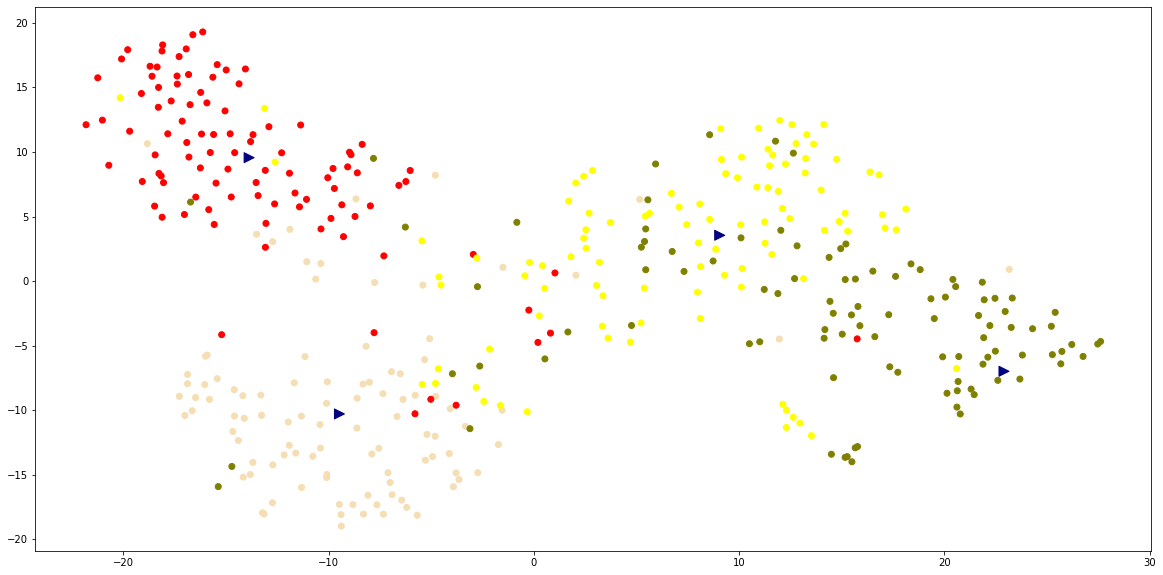

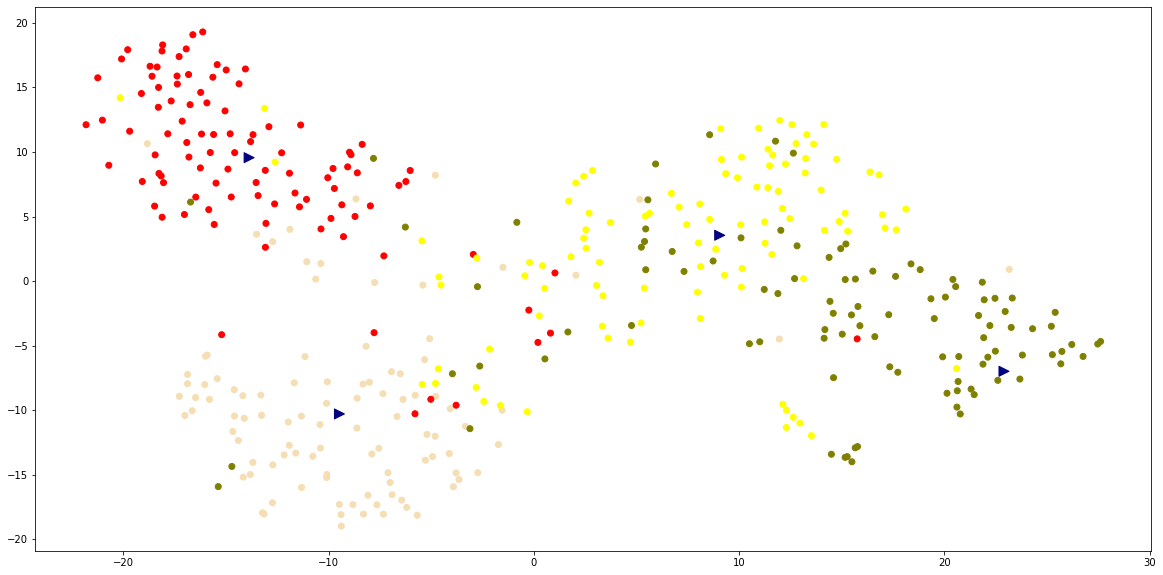

In [74]:
k_means_tsne_summary(new_train_feature_matrix, train_labels)

In [92]:
from sklearn.decomposition import IncrementalPCA  # inital reduction
from sklearn.manifold import TSNE  # final reduction
import numpy as np  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = []  # positions in vector space
    labels = []  # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)


def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode="text", text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename="word-embedding-plot")
    else:
        plot(data, filename="word-embedding-plot.html")


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))


try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

ModuleNotFoundError: No module named 'plotly'

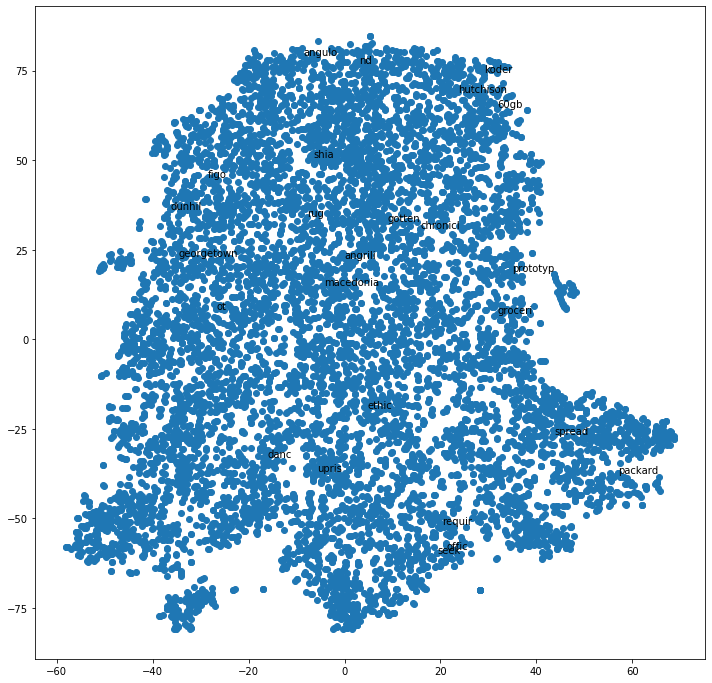

In [94]:
plot_with_matplotlib(x_vals, y_vals, labels)